In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import ensemble

This task will use the Boston dataset from sklearn.datasets. Leave the last 25% of objects for quality control by dividing X and y into X_train, y_train and X_test, y_test.

In [0]:
boston = load_boston()
print(boston.data.shape)

(506, 13)


In [0]:
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.75)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

### Task 1

As you already know from the lectures, boosting is a method for constructing compositions of basic algorithms by successively adding a new algorithm to the current composition with a certain coefficient. Gradient boosting teaches each new algorithm so that it approximates the  anti-gradient error by the answers of current composition on the training set. Similar to the minimization of functions using the gradient descent method, in the gradient boosting we correct the composition by changing the algorithm in the direction of the anti-gradient error. Use the formula from the lectures defining the answers in the training sample for which you need to train the new algorithm (in fact, it is only a little more detailed gradient from the error), and get its particular case if the loss function L is the square of the response deviation of the composition a (x) from correct answer y on given x.

If you have not considered the derivative yourself for a long time, you will be helped by a table of derivatives of elementary functions (which can be easily found on the Internet) and the rule of differentiation of a complex function. After differentiating the square, you will have a factor of 2 - because we will still have to choose the coefficient with which the new basic algorithm will be added, lose this factor in the further construction of the algorithm.

In [0]:
def L_derivative(y_train, z):
    return (y_train - z)

### Task 2

Create an array for DecisionTreeRegressor objects (we will use them as basic algorithms) and for real numbers (these will be coefficients before basic algorithms). Train 50 decision trees with parameters max_depth = 5 and random_state = 42 in the cycle (the other parameters are by default). In the boosting, hundreds and thousands of trees are often used, but we will limit ourselves to 50 so that the algorithm runs faster and it is easier to debug it (because the goal of the task is to figure out how the method works). Each tree should be trained on the same set of objects, but the answers will change in accordance with the rule obtained in task 1. Try to start with a factor of 0.9. It is usually justified to choose a coefficient that is much smaller - about 0.05 or 0.1, but since In our educational example, there will be only 50 trees on a standard dataset, let's take a bigger step to start.

In the process of implementing the training, you will need a function that will calculate the forecast of the currently constructed tree composition on sample X:

In [0]:
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

In [0]:
base_algorithms_list = []
coefficients_list = []

z = np.zeros( (y_train.shape) )

for _ in range(50):
    coefficients_list.append(0.9)
    dt_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)
    dt_regressor.fit(X_train, L_derivative(y_train, z))
    base_algorithms_list.append(dt_regressor)
    z = gbm_predict(X_train)
    
alg_predict = gbm_predict(X_test)
alg_rmse = np.sqrt(mean_squared_error(y_test, alg_predict))
print(alg_rmse)

4.378145621020009


### Task 3

You may also be concerned that, moving at a constant pace, near the minimum of the error, the answers in the training set change too abruptly, jumping over the minimum.

Try to reduce the weight before each algorithm with each subsequent iteration using the formula 0.9 / (1.0 + i), where i is the iteration number (from 0 to 49). Use the quality of the algorithm as the answer in step 3.

In reality, the following step selection strategy is often used: as soon as an algorithm is selected, we select the coefficient in front of it by a numerical optimization method so that the deviation from the correct answers is minimal. We will not offer you to implement it for the assignment, but we recommend trying to figure out such a strategy and implement it on occasion for yourself.

In [0]:
base_algorithms_list = []
coefficients_list = []

z = np.zeros( (y_train.shape) )

for i in range(50):
    coeff = 0.9 / (1. + i)
    coefficients_list.append(coeff)
    dt_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)
    dt_regressor.fit(X_train, L_derivative(y_train, z))
    base_algorithms_list.append(dt_regressor)
    z = gbm_predict(X_train)
    
alg_predict = gbm_predict(X_test)
alg_rmse = np.sqrt(mean_squared_error(y_test, alg_predict))
alg_predict_train = gbm_predict(X_train)
print(alg_rmse)

4.019603275119203


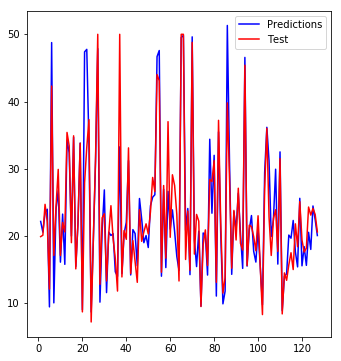

In [0]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(alg_predict)) + 1, alg_predict, 'b-',
         label='Predictions')
plt.plot(np.arange(len(alg_predict)) + 1, y_test, 'r-',
         label='Test')
plt.legend(loc='upper right')

Compare the quality obtained using the gradient boost with the quality of the linear regression operation.

To do this, train LinearRegression from sklearn.linear_model (with default parameters) on the training set and evaluate the predictions of the obtained algorithm on the RMSE test set. The quality received is the answer in clause 5.

In this example, the quality of work of a simple model should have been worse, but one should not forget that this is not always the case. In the assignments for this course you will find an example of the reverse situation.

In [0]:
lr_regressor = LinearRegression()
lr_regressor.fit(X_train, y_train)
    
alg_predict = lr_regressor.predict(X_test)
alg_rmse = np.sqrt(mean_squared_error(y_test, alg_predict))
print(alg_rmse)

5.2615128390483745


In [0]:
params = {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.9, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print(mse)


19.710626095913863


Text(0, 0.5, 'Deviance')

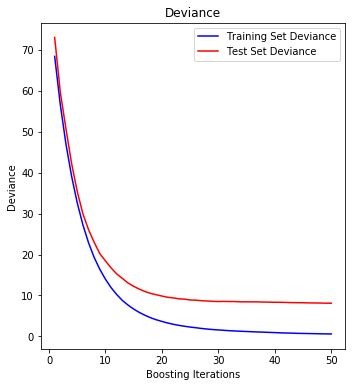

In [0]:
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)
    

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

